# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface. The basic model is fairly simple, so we also solve it parametrically to find the efficient frontier.

**Download the Repository** <br />
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip).


## Model Formulation

\begin{equation}
    \min \sum_{i=1}^{N}\sum_{i=j+1}^{N}w_{i}w_{j}\sigma_{ij} \\
\end{equation}

\begin{equation}
\sum_{i=1}^{N} \mu_{i} x_{i} \geq \mu_{0}
\end{equation}

\begin{equation}
\sum_{i=1}^{N}w_{i} = 1
\end{equation}

\begin{equation}
\ell_{i}z_{i} \leq w_{i} \leq \delta_{i}z_{i}  \ \ \ \forall i = 1, . . . ,N
\end{equation}

\begin{equation}
\sum_{i=1}^{N}z_{i} \leq K
\end{equation}

\begin{equation}
w_{i} \geq 0 \ \ \ \forall i = 1, . . . ,N
\end{equation}




\begin{equation}
z_{i} \in \{0, 1\} \ \ \ \forall i = 1, . . . ,N
\end{equation}

### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\sigma$: n x n matrix measuring the covariance among stocks
- $\\ell$: Minimal proportion if asset $i$ traded
- $\delta$: Maximal proportion if asset $i$ traded

There is one additional parameter when solving the model parametrically:

- $\mu$: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}

Buy-in threshold: 


In [17]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf

import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from docplex.mp.model import Model


pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

### Functions

In [18]:
def display_pie(pie_values, pie_labels, colors=None, title=''):

    """
        Displys a pie chart with assests and its respective allocation fraction.

    Args:
        pie_values (_type_): _description_
        pie_labels (_type_): _description_
        colors (_type_, optional): _description_. Defaults to None.
        title (str, optional): _description_. Defaults to ''.
    """

    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()



def load_data(file_path=None, start= datetime.datetime(2020,1,1), end = datetime.datetime.now()):

    """
        Load assest data from a specific file path or download predefined data from yahoo finance

    Returns:
        _type_: _description_
    """

    start_date = start
    end_date   = end

    if file_path:
        data = pd.read_csv(file_path)

    else:
        assets = ['VALE3', 'GGBR4', 'CPLE6', 'BBSE3', 'ITUB4', 'WEGE3', 'JBSS3', 'PRIO3', 'MULT3', 'ITSA4', 'ABEV3', 'ALPA4',
          'ARZZ3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3', 'BBDC4', 'BEEF3', 'BHIA3', 'BPAC11', 'BRAP4','BRFS3', 'BRKM5']

        tickers = (pd.Series(assets)+'.SA').tolist()

        data  = yf.download(tickers=tickers, start=start_date, end = end_date, rounding=True)['Adj Close']

        data.columns = assets

    return data

### Read Stock Data

In [19]:
start_date = datetime.datetime(2020,1,1)
end_date   = datetime.datetime.now()

In [20]:
stocks = load_data(None, start_date, end_date)

stocks.head()

[*********************100%%**********************]  24 of 24 completed


,VALE3,GGBR4,CPLE6,BBSE3,ITUB4,WEGE3,JBSS3,PRIO3,MULT3,ITSA4,ABEV3,ALPA4,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BHIA3,BPAC11,BRAP4,BRFS3,BRKM5
Date,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,16.18,32.15,59.35,58.80,12.87,15.52,21.74,23.18,26.19,9.79,256.57,17.31,8.54,34.15,25.86,4.64,11.07,9.25,31.51,21.48,29.70,7.14,36.41,16.54
2020-01-03,15.95,32.15,58.51,56.76,12.50,15.49,21.41,23.19,25.90,10.04,251.10,17.36,8.66,34.21,27.01,4.64,10.89,9.11,31.18,21.69,29.70,7.56,36.15,16.33
2020-01-06,16.02,31.64,58.15,55.00,12.38,15.29,21.28,22.78,26.32,10.04,251.10,17.34,8.70,33.86,28.41,4.65,10.86,9.09,30.72,21.18,29.65,7.71,35.93,16.37
2020-01-07,16.06,32.36,58.42,56.82,12.78,15.17,20.92,22.38,26.34,10.49,254.82,17.41,8.74,33.47,27.67,4.67,11.03,8.97,30.00,21.56,29.73,7.72,36.19,16.50
2020-01-08,15.98,32.72,57.58,56.92,12.74,15.03,20.60,22.04,26.32,10.61,253.73,17.25,8.74,34.75,29.06,4.60,11.08,8.83,29.51,22.09,29.85,7.56,36.20,15.88


In [21]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1083 entries, 2020-01-02 to 2024-05-10
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALE3   1083 non-null   float64
 1   GGBR4   1083 non-null   float64
 2   CPLE6   1083 non-null   float64
 3   BBSE3   1083 non-null   float64
 4   ITUB4   1083 non-null   float64
 5   WEGE3   1083 non-null   float64
 6   JBSS3   1083 non-null   float64
 7   PRIO3   1083 non-null   float64
 8   MULT3   1083 non-null   float64
 9   ITSA4   1083 non-null   float64
 10  ABEV3   1083 non-null   float64
 11  ALPA4   1083 non-null   float64
 12  ARZZ3   1083 non-null   float64
 13  AZUL4   1083 non-null   float64
 14  B3SA3   1083 non-null   float64
 15  BBAS3   1083 non-null   float64
 16  BBDC3   1083 non-null   float64
 17  BBDC4   1083 non-null   float64
 18  BEEF3   1083 non-null   float64
 19  BHIA3   1083 non-null   float64
 20  BPAC11  1083 non-null   float64
 21  BRAP4   1083 non-nu

In [22]:
prices = stocks.copy()

start_train_range = datetime.datetime(2020, 1, 1)
end_test_range    = datetime.datetime(2022, 12, 31)

In [23]:
train = prices.loc[(prices.index >= start_train_range) & (prices.index <= end_test_range)]
print(train.shape)
train.tail()

(745, 24)


,VALE3,GGBR4,CPLE6,BBSE3,ITUB4,WEGE3,JBSS3,PRIO3,MULT3,ITSA4,ABEV3,ALPA4,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BHIA3,BPAC11,BRAP4,BRFS3,BRKM5
Date,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-23,13.89,14.80,78.51,11.45,12.73,14.68,12.03,13.67,29.18,11.90,56.00,23.78,24.94,7.52,23.75,7.39,20.96,7.35,23.06,19.99,21.60,35.43,77.71,37.52
2022-12-26,13.80,14.68,76.29,11.36,12.80,14.66,11.75,13.34,28.89,11.60,55.78,23.19,24.98,7.44,23.29,7.34,20.58,7.26,22.61,19.92,21.04,35.38,78.42,37.21
2022-12-27,13.80,14.45,74.36,10.74,12.35,14.17,11.83,13.28,28.84,11.76,51.84,22.65,25.58,7.19,23.93,7.27,21.60,7.18,22.48,19.94,20.32,35.52,80.29,37.04
2022-12-28,13.83,15.12,76.41,11.16,12.78,14.43,12.19,13.68,29.22,12.00,53.59,23.77,25.62,7.76,24.01,7.55,21.50,7.33,22.94,20.49,21.14,37.19,80.11,37.71
2022-12-29,13.80,15.08,75.99,11.01,12.60,14.45,12.13,13.67,29.29,12.22,52.50,23.23,25.35,8.28,23.76,7.58,21.44,7.29,22.89,20.82,20.94,37.15,80.01,37.53


In [24]:
oos = prices.loc[(prices.index >= end_test_range)]
print(oos.shape)
oos.tail()

(338, 24)


,VALE3,GGBR4,CPLE6,BBSE3,ITUB4,WEGE3,JBSS3,PRIO3,MULT3,ITSA4,ABEV3,ALPA4,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BHIA3,BPAC11,BRAP4,BRFS3,BRKM5
Date,,,,,,,,,,,,,,,,,,,,,,,,
2024-05-06,12.45,9.78,51.75,10.93,11.51,28.38,12.32,13.77,33.26,6.01,6.97,35.15,20.30,16.18,19.70,9.55,19.64,9.83,32.40,23.88,24.41,47.19,64.18,38.63
2024-05-07,12.60,9.68,51.79,10.96,11.58,28.29,12.36,13.77,32.80,6.02,7.03,35.32,20.33,16.65,20.05,9.56,19.31,9.98,33.07,24.31,24.07,47.17,64.58,38.90
2024-05-08,12.17,9.80,51.98,11.12,11.67,28.38,12.28,13.80,32.62,6.08,6.96,34.61,20.21,18.51,19.71,9.54,19.45,10.09,33.28,24.47,23.96,46.54,63.99,39.09
2024-05-09,12.05,9.96,49.75,11.08,11.21,27.14,11.96,13.45,32.62,6.24,7.12,33.21,20.28,18.91,19.28,9.24,19.35,9.93,32.28,24.61,23.44,46.78,64.51,38.90
2024-05-10,12.04,10.29,47.82,11.03,10.94,27.62,11.95,13.37,33.13,6.34,6.81,33.52,20.10,18.32,19.06,9.13,19.14,10.04,32.65,24.62,23.65,47.00,64.29,38.97


In [25]:
daily_returns = prices.pct_change()
daily_returns = daily_returns.iloc[1:]               # deletes the first row that has no daily return
daily_returns = daily_returns.dropna(axis='columns') # filter out stocks with NaNs

In [26]:
std   = daily_returns.std()
delta = daily_returns.mean()

### Model Validation

In [27]:
from docplex.mp.environment import Environment
Environment().print_information()

* system is: Windows 64bit
* Python version 3.8.19, located at: c:\Users\toni\anaconda3\envs\ab-research\python.exe
* docplex is present, version is 2.25.236
* CPLEX library is present, version is 22.1.0.0, located at: C:\Program Files\IBM\ILOG\CPLEX_Studio221\cplex\python\3.8\x64_win64
* pandas is present, version is 2.0.3


In [28]:
PORT_TOTAL_SUM           = 1
PORT_MAX_ASSET_ALOCATION = 0.20
PORT_MIN_ASSET_ALOCATION = 0.05
PORT_EXPECTED_RETURN     = 0.01
PORT_NUMBER_OF_ASSETS    = 10
ASSETS                   = stocks.columns.to_list()
WINDOW_SIZE, HORIZON     = len(train), 7

keys = list(ASSETS)

In [29]:
def get_max_return(asset_returns):

    mdl = Model(name='max_expected_return')
    w = mdl.continuous_var_dict(keys, name='asset')
    z = mdl.binary_var_dict(keys, name='asset_z')

    mdl.add_constraint(mdl.sum(w[i] for i in keys) == PORT_TOTAL_SUM, ctname="ct_total_weight") 
    mdl.add_constraints((w[i] <= PORT_MAX_ASSET_ALOCATION for i in keys), names= ['ct_asset_' + key  for key in keys]) 

    # Force x to 0 if not traded - Indicator
    mdl.add_constraints(w[i] <= z[i] for i in keys)

    # Minimal position;
    mdl.add_constraints(w[i] >= PORT_MIN_ASSET_ALOCATION * z[i] for i in keys)

    # Cardinality constraint: at most K positions
    mdl.add_constraint(mdl.sum(z[i] for i in keys) == PORT_NUMBER_OF_ASSETS)

    delta = asset_returns

    r = mdl.sum(w[i] * delta.to_dict()[i] for i in keys)

    mdl.maximize(r)

    mdl.solve(log_output=False, clean_before_solve = True)
    
    print(f'Retorno máximo esperado: {mdl.objective_value}')

    return mdl.objective_value

In [30]:
def walk_forward_validation(data, WINDOW_SIZE, HORIZON, sliding=True):

    num_assets            = len(prices.columns)
    SHOW_OUTPUT_LOG       = True
    exp_reduced_percents  = [0, 10, 20, 30, 40, 50]
    portfolio             = pd.DataFrame()
        
    for val in exp_reduced_percents:

        portfolios_by_windows = pd.DataFrame()

        # Walk Forward Validation
        for idx in range(0, len(data) - WINDOW_SIZE, HORIZON):


            train_start = 0

            if sliding:
                train_start = idx

            train_end   = idx + WINDOW_SIZE
            test_start  = idx + WINDOW_SIZE
            test_end    = idx + WINDOW_SIZE + HORIZON

            # Split data - TRAIN
            train = prices[train_start:train_end]
            valid = prices[test_start:test_end]

            daily_returns = train.pct_change()
            daily_returns = daily_returns.iloc[1:]               # Deletes the first row that has no daily return
            daily_returns = daily_returns.dropna(axis='columns') # Filter out stocks with NaNs
            
            sigma = np.array(daily_returns.cov())
            mu    = daily_returns.mean()

            # Split data - TEST
            valid_daily_returns = valid.pct_change()
            valid_daily_returns = valid_daily_returns.iloc[1:]               # Deletes the first row that has no daily return
            valid_daily_returns = valid_daily_returns.dropna(axis='columns') # Filter out stocks with NaNs  

            # Create model ======================================================================================================
            model = Model(name='mvo_model')

            w = {idx: model.continuous_var(name='{}'.format(label)) for idx, label in enumerate(prices.columns)}
            z = {idx: model.binary_var(name='z_{}'.format(label)) for idx, label in enumerate(prices.columns)}

            # Define constraints
            model.add_constraint(model.sum(w[i] for i in range(num_assets)) == 1)  # Total investment equals 100%
            model.add_constraint(model.sum(w[i] for i in range(num_assets)) == PORT_TOTAL_SUM, ctname="ct_total_weight")  # Total portfolio weight
            model.add_constraints((w[i] <= PORT_MAX_ASSET_ALOCATION for i in range(num_assets)))                          # Max asset allocation
            model.add_constraints(w[i] <= z[i] for i in range(num_assets))                                                # Force x to 0 if not traded - Indicator
            model.add_constraints(w[i] >= PORT_MIN_ASSET_ALOCATION * z[i] for i in range(num_assets))                     # Minimal position;
            model.add_constraint(model.sum(z[i] for i in range(num_assets)) == PORT_NUMBER_OF_ASSETS)                     # Cardinality constraint: at most K positions

            max_portfolio_return = get_max_return(mu) # Update expected return to MVP

            # Decrease max expected return
            max_portfolio_return = max_portfolio_return - (max_portfolio_return*(val/100))

            if SHOW_OUTPUT_LOG:
                print(f"Decrease Expected Return by {val}% -  Actual Expected Return:{max_portfolio_return}") # adicionar em um novo DF
                
            variance = model.sum(0.5 * sigma[i, j] * w[i] * w[j] if i==j else sigma[i, j] * w[i] * w[j] for i in range(sigma.shape[0]) for j in range(i, sigma.shape[1]))

            model.minimize(variance)
            model.solve(log_output=False, clean_before_solve = True)

            weights_dict = {i: w[i].solution_value for i in range(num_assets)}
            weights = pd.DataFrame([weights_dict])

            min_portfolio_return = mu @ weights.iloc[0].values

            # Create an expression representing the expected return for the portfolio
            mu = np.array(mu)
            target = model.add_constraint(model.sum(w[i] * mu[i] for i in range(num_assets)) >= max_portfolio_return , ctname="ct_exp_return")

            target.rhs = max_portfolio_return
            model.solve(log_output=False, clean_before_solve = True)

            # Get best weights
            weights = pd.DataFrame([{i: w[i].solution_value for i in range(num_assets)}])

            # Apply weigths to 7-day window
            week_portfolio                                  = valid_daily_returns * weights.iloc[0].values
            week_portfolio['portfolio_risk']                = week_portfolio[ASSETS].std(axis=1)
            week_portfolio['portfolio_variance']            = model.objective_value
            week_portfolio['portfolio_std_variance']        = np.sqrt(model.objective_value)
            week_portfolio['portfolio_return']              = week_portfolio[ASSETS].mean(axis=1)
            week_portfolio['portfolio_max_exp_return']      = max_portfolio_return
            week_portfolio['portfolio_max_exp_return_frac'] = val

            if SHOW_OUTPUT_LOG:
                print(f"Train window {train_start} to {train_end} - Test window {test_start} to {test_end}")
                print(f"Train: {train.index.min()} - {train.index.max()}")
                print(f"Valid: {valid.index.min()} - {valid.index.max()}")
                print(f"Retorno Esperado do Portfolio de Var. Min: {min_portfolio_return}")
                print(f"Variância encontrada pela função objetivo: {model.objective_value}")
                print(f"Total sum of weights: {sum(weights.iloc[0].values)}")
                print('--')

            portfolios_by_windows = pd.concat([portfolios_by_windows, week_portfolio])
                
        portfolio = pd.concat([portfolio, portfolios_by_windows])

    return portfolio



In [31]:
# TODO: Extract model for a single function
def get_model():
    pass

In [32]:
%%time
portfolio = walk_forward_validation(prices, WINDOW_SIZE, HORIZON, sliding=True)

Retorno máximo esperado: 0.0017646602766343963
Decrease Expected Return by 0% -  Actual Expected Return:0.0017646602766343963
Train window 0 to 745 - Test window 745 to 752
Train: 2020-01-02 00:00:00 - 2022-12-29 00:00:00
Valid: 2023-01-02 00:00:00 - 2023-01-10 00:00:00
Retorno Esperado do Portfolio de Var. Min: 0.0005610357915146642
Variância encontrada pela função objetivo: 0.00027525987566244883
Total sum of weights: 1.0
--
Retorno máximo esperado: 0.0017188220030757342
Decrease Expected Return by 0% -  Actual Expected Return:0.0017188220030757342
Train window 7 to 752 - Test window 752 to 759
Train: 2020-01-13 00:00:00 - 2023-01-10 00:00:00
Valid: 2023-01-11 00:00:00 - 2023-01-19 00:00:00
Retorno Esperado do Portfolio de Var. Min: 0.0005700044724249612
Variância encontrada pela função objetivo: 0.0002752727390594117
Total sum of weights: 1.000000000000003
--
Retorno máximo esperado: 0.001691201669760339
Decrease Expected Return by 0% -  Actual Expected Return:0.001691201669760339
T

In [17]:
df = portfolio[portfolio['portfolio_max_exp_return_frac'] == 0]
print(f"Dataframe shape: {df.shape} - {df.index.min()} - {df.index.max()}")
df.head()

Dataframe shape: (289, 30) - 2023-01-03 00:00:00 - 2024-05-10 00:00:00


,VALE3,GGBR4,CPLE6,BBSE3,ITUB4,WEGE3,JBSS3,PRIO3,MULT3,ITSA4,ABEV3,ALPA4,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BHIA3,BPAC11,BRAP4,BRFS3,BRKM5,portfolio_risk,portfolio_variance,portfolio_std_variance,portfolio_return,portfolio_max_exp_return,portfolio_max_exp_return_frac
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-03,-0.0,-0.0,-0.001556,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.001419,-0.0,-0.002393,-0.001495,-0.0,-0.001637,-0.000956,0.000093,-0.0,-0.0,-0.0,-0.0,-0.013406,-0.000174,-0.005009,0.002861,0.000551,0.023463,-0.001165,0.001765,0
2023-01-04,0.0,0.0,0.001147,0.0,0.0,0.0,0.0,0.0,0.0,0.001890,0.0,0.001595,0.001903,0.0,-0.000111,0.001393,-0.000232,0.0,0.0,0.0,0.0,-0.001168,0.000174,0.001326,0.000769,0.000551,0.023463,0.000330,0.001765,0
2023-01-05,0.0,0.0,0.000596,0.0,0.0,0.0,0.0,0.0,0.0,0.001035,0.0,0.002014,0.004949,0.0,0.001517,-0.000339,0.001235,0.0,0.0,0.0,0.0,0.005112,0.001677,0.000439,0.001463,0.000551,0.023463,0.000760,0.001765,0
2023-01-06,0.0,0.0,0.000984,0.0,0.0,0.0,0.0,0.0,0.0,0.000730,0.0,0.000293,0.000690,0.0,0.000303,-0.000750,0.000387,0.0,0.0,0.0,0.0,0.001203,0.001589,0.002957,0.000742,0.000551,0.023463,0.000349,0.001765,0
2023-01-09,0.0,0.0,-0.000509,0.0,-0.0,-0.0,0.0,0.0,0.0,0.000320,0.0,-0.000470,0.002521,0.0,0.000344,-0.000485,0.001016,0.0,0.0,0.0,-0.0,0.004727,0.000108,-0.000594,0.001123,0.000551,0.023463,0.000291,0.001765,0


In [18]:
df = portfolio[portfolio['portfolio_max_exp_return_frac'] == 0]
print(f"Dataframe shape: {df.shape} - {df.index.min()} - {df.index.max()}")
df.head()

Dataframe shape: (289, 30) - 2023-01-03 00:00:00 - 2024-05-10 00:00:00


,VALE3,GGBR4,CPLE6,BBSE3,ITUB4,WEGE3,JBSS3,PRIO3,MULT3,ITSA4,ABEV3,ALPA4,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BHIA3,BPAC11,BRAP4,BRFS3,BRKM5,portfolio_risk,portfolio_variance,portfolio_std_variance,portfolio_return,portfolio_max_exp_return,portfolio_max_exp_return_frac
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-03,-0.0,-0.0,-0.001556,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.001419,-0.0,-0.002393,-0.001495,-0.0,-0.001637,-0.000956,0.000093,-0.0,-0.0,-0.0,-0.0,-0.013406,-0.000174,-0.005009,0.002861,0.000551,0.023463,-0.001165,0.001765,0
2023-01-04,0.0,0.0,0.001147,0.0,0.0,0.0,0.0,0.0,0.0,0.001890,0.0,0.001595,0.001903,0.0,-0.000111,0.001393,-0.000232,0.0,0.0,0.0,0.0,-0.001168,0.000174,0.001326,0.000769,0.000551,0.023463,0.000330,0.001765,0
2023-01-05,0.0,0.0,0.000596,0.0,0.0,0.0,0.0,0.0,0.0,0.001035,0.0,0.002014,0.004949,0.0,0.001517,-0.000339,0.001235,0.0,0.0,0.0,0.0,0.005112,0.001677,0.000439,0.001463,0.000551,0.023463,0.000760,0.001765,0
2023-01-06,0.0,0.0,0.000984,0.0,0.0,0.0,0.0,0.0,0.0,0.000730,0.0,0.000293,0.000690,0.0,0.000303,-0.000750,0.000387,0.0,0.0,0.0,0.0,0.001203,0.001589,0.002957,0.000742,0.000551,0.023463,0.000349,0.001765,0
2023-01-09,0.0,0.0,-0.000509,0.0,-0.0,-0.0,0.0,0.0,0.0,0.000320,0.0,-0.000470,0.002521,0.0,0.000344,-0.000485,0.001016,0.0,0.0,0.0,-0.0,0.004727,0.000108,-0.000594,0.001123,0.000551,0.023463,0.000291,0.001765,0


- **portfolio_risk**           = cada ponto é uma media desse cara
- **portfolio_return**         = cada ponto é uma media desse cara
- **portfolio_max_exp_return** = (from in sample) Esse cara tem que vir o In sample

In [33]:
from collections import deque

exp_reduced_percents  = [50, 40, 30, 20, 10, 0]

lists = deque()

for frac in exp_reduced_percents:
    df = portfolio[portfolio['portfolio_max_exp_return_frac'] == frac]
    row = [df['portfolio_risk'].mean(), df['portfolio_return'].mean()]
    print(row)
    lists.append(row)

frontier = np.array(lists)
risks    = [row[0] for row in frontier]
returns  = [row[1] for row in frontier]

[0.0009624566020292953, 3.2063152911621274e-06]
[0.0009543362288538066, 3.560173329281265e-06]
[0.0009738801135904861, 2.935857157690406e-06]
[0.0010167258831978087, 2.6683798343446764e-06]
[0.0010770116019690856, 3.5499920566367827e-06]
[0.001191585249634751, -1.3094402635097764e-06]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


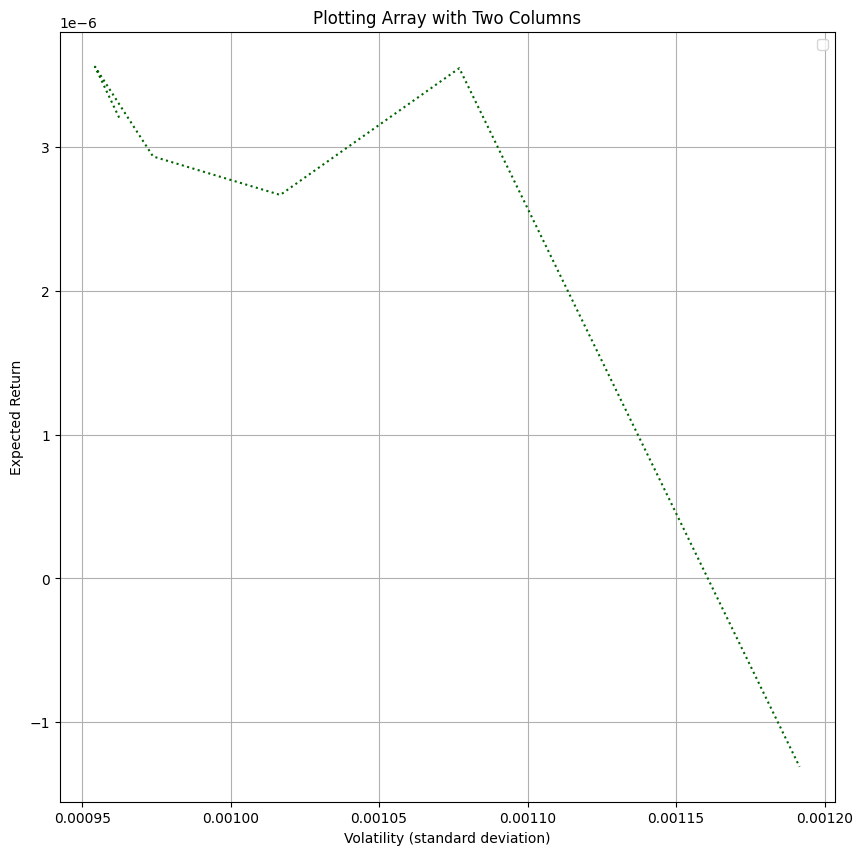

In [34]:
# Plotting

fig, ax = plt.subplots(figsize=(10,10))

# # Plot volatility versus expected return for individual stocks
# ax.scatter(x=std, y=delta,
#            color='Blue', label='Individual Stocks')

# for i, stock in enumerate(ASSETS):
#     ax.annotate(stock, (std[i], delta[i]))

plt.plot(risks, returns, color='DarkGreen', linestyle='dotted')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plotting Array with Two Columns')
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x = risks,
                    y = returns,
                    mode = 'markers',
                    name = 'Efficient Frontier'))

fig.update_layout(xaxis=dict(title='Annualised Portfolio Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Efficient Frontier - Portfolios',
                  width=1400,
                  height=800)

fig.update_traces(mode='markers+lines')
fig.show()

- https://ibmdecisionoptimization.github.io/tutorials/html/Beyond_Linear_Programming.html